In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set_style('white')
sns.set_color_codes('deep')

In [3]:
# read in 2012 math performance data (https://data.oecd.org/pisa/mathematics-performance-pisa.htm)
df = pd.read_csv('DP_LIVE_24092023123623831.csv')

In [4]:
df

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,AUS,PISAMATH,BOY,MEANSCORE,A,2003,527.000,NaN
1,AUS,PISAMATH,BOY,MEANSCORE,A,2006,527.000,NaN
2,AUS,PISAMATH,BOY,MEANSCORE,A,2009,519.000,NaN
3,AUS,PISAMATH,BOY,MEANSCORE,A,2012,510.115,NaN
4,AUS,PISAMATH,BOY,MEANSCORE,A,2015,497.000,NaN
...,...,...,...,...,...,...,...,...
695,CRI,PISAMATH,BOY,MEANSCORE,A,2018,411.000,NaN
696,CRI,PISAMATH,GIRL,MEANSCORE,A,2018,394.000,NaN
697,LTU,PISAMATH,TOT,MEANSCORE,A,2018,481.000,NaN
698,LTU,PISAMATH,BOY,MEANSCORE,A,2018,480.000,NaN


## Wrangle

Country codes are handy but can be hard to decipher—supplement with proper names.

In [5]:
# read in country code data (https://www.iban.com/country-codes)
cc_df = pd.read_csv('COUNTRY_CODES_ALPHA-2_&_ALPHA-3.csv',
                    sep=';',
                    usecols=['Country', 'Alpha-3 code'])

In [6]:
cc_df.head()

,Country,Alpha-3 code
0,Afghanistan,AFG
1,Åland Islands,ALA
2,Albania,ALB
3,Algeria,DZA
4,American Samoa,ASM


In [7]:
# rename "key" column for merge...
cc_df = cc_df.rename(columns={'Alpha-3 code': 'LOCATION'})

In [8]:
# add country names to main dataframe
df = pd.merge(df, cc_df, on='LOCATION', how='left')

In [9]:
df.head()

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes,Country
0,AUS,PISAMATH,BOY,MEANSCORE,A,2003,527.000,NaN,Australia
1,AUS,PISAMATH,BOY,MEANSCORE,A,2006,527.000,NaN,Australia
2,AUS,PISAMATH,BOY,MEANSCORE,A,2009,519.000,NaN,Australia
3,AUS,PISAMATH,BOY,MEANSCORE,A,2012,510.115,NaN,Australia
4,AUS,PISAMATH,BOY,MEANSCORE,A,2015,497.000,NaN,Australia


Drop superfluous columns.

In [10]:
# pull up 2012 avg. scores by country—code and name
df_tot_2012 = df.query('SUBJECT == "TOT" and TIME == 2012')[['LOCATION', 'Country', 'Value']]

In [11]:
df_tot_2012.head()

,LOCATION,Country,Value
449,AUS,Australia,504.0
454,AUT,Austria,506.0
460,BEL,Belgium,515.0
466,CAN,Canada,518.0
472,CZE,Czechia,499.0


## Explore

In [12]:
df_tot_2012.describe()

,Value
count,39.000000
mean,487.923077
std,37.195348
min,375.000000
25%,481.500000
50%,494.000000
75%,510.000000
max,554.000000


In [13]:
df_tot_2012.query('LOCATION == "CAN" or LOCATION == "USA"')

,LOCATION,Country,Value
466,CAN,Canada,518.0
621,USA,United States of America (the),481.0


📝 Canada is top-quartile, and the United States is bottom-quartile:

In [14]:
# bin the scores into quartiles
df_tot_2012['Quartile'] = pd.qcut(df_tot_2012.Value, [0, .25, .5, .75, 1.], labels=['bottom', 'lower-mid', 'upper-mid', 'top'])

In [15]:
df_tot_2012.query('LOCATION == "CAN" or LOCATION == "USA"')

,LOCATION,Country,Value,Quartile
466,CAN,Canada,518.0,top
621,USA,United States of America (the),481.0,bottom


### Visualize

In [16]:
df_tot_2012_sort = df_tot_2012.sort_values('Value')

In [17]:
df_tot_2012_sort.head()

,LOCATION,Country,Value,Quartile
643,IDN,Indonesia,375.0,bottom
627,BRA,Brazil,389.0,bottom
550,MEX,Mexico,413.0,bottom
632,CHL,Chile,423.0,bottom
610,TUR,Turkey,448.0,bottom


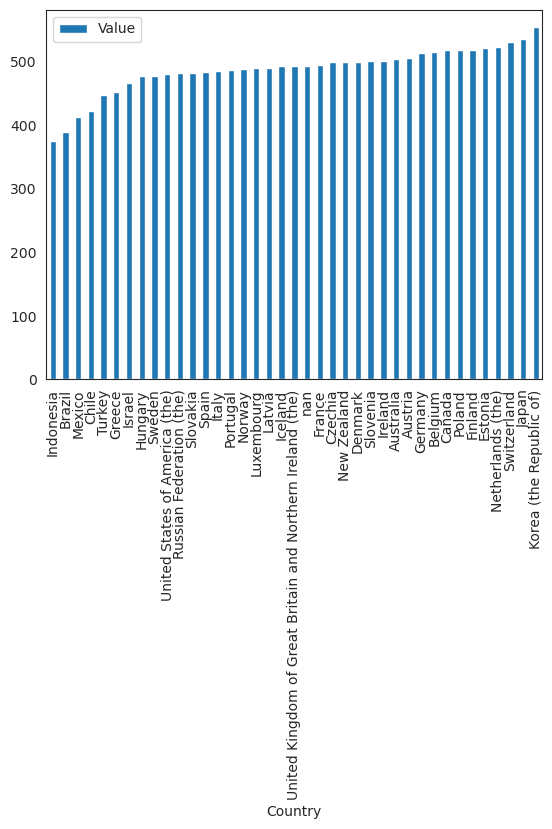

In [18]:
df_tot_2012_sort.plot.bar('Country', 'Value');

In [19]:
# replace overly long country labels, as well as that NaN—how'd that get there!
replace_dict = {
    'United States of America (the)': 'United States',
    'Russian Federation (the)': 'Russia',
    'United Kingdom of Great Britain and Northern Ireland (the)': 'United Kingdom',
    'nan': 'OECD Average',
    'Netherlands (the)': 'Netherlands',
    'Korea (the Republic of)': 'South Korea',
}

df_tot_2012_sort['Country'] = df_tot_2012_sort['Country'].astype(str)
df_tot_2012_sort['Country'] = df_tot_2012_sort['Country'].replace(replace_dict)

📝 As for the data, it is concentrated in a narrow band ie the numbers are close together—relative to zero. Furthermore, the data appears skewed, and it may contain outliers.

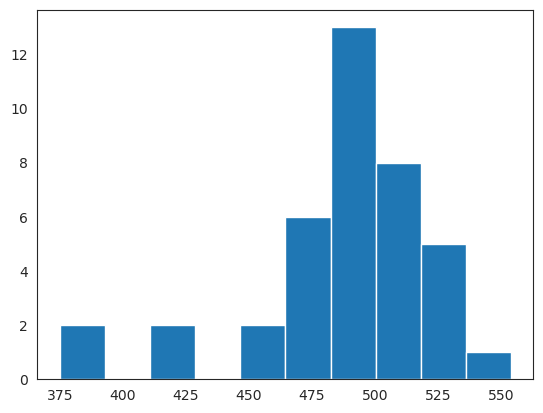

In [20]:
plt.hist(df_tot_2012['Value']);

### Test

In [21]:
# test for outliers using IQR
q1 = df_tot_2012.Value.quantile(0.25)
q3 = df_tot_2012.Value.quantile(0.75)
iqr = q3 - q1

np.any((df_tot_2012.Value > q3 + 1.5*iqr) | (df_tot_2012.Value < q1 - 1.5*iqr))

True

$z = \dfrac{x - μ}{σ}$

In [22]:
# test for outliers using z-scores
mu = df_tot_2012.Value.mean()
sigma = df_tot_2012.Value.std()

np.any(abs((df_tot_2012.Value - mu) / sigma) > 3)

True

## Explain

### Visualize

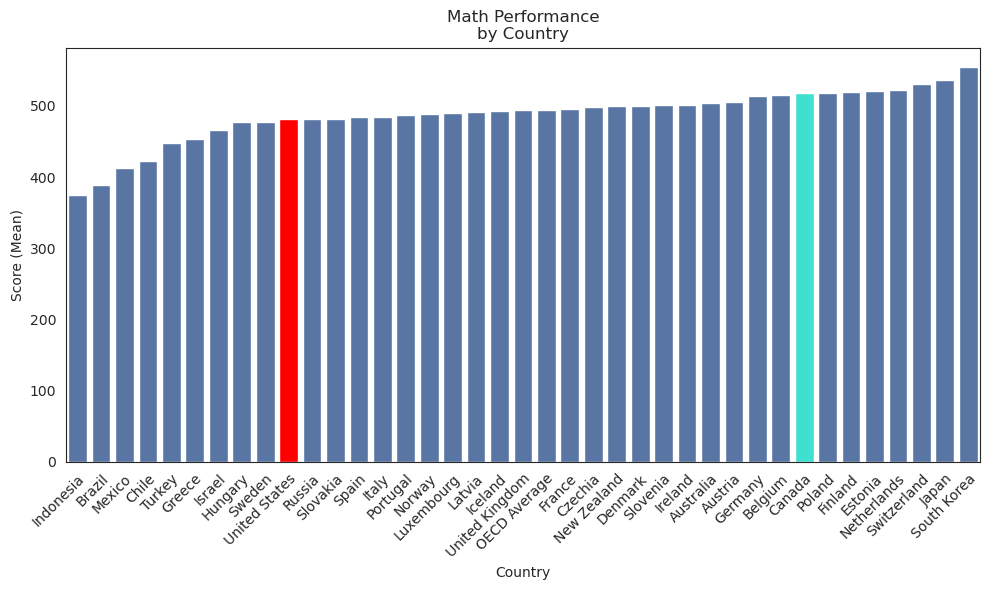

In [23]:
plt.figure(figsize=(10,6))
ax = sns.barplot(x=df_tot_2012_sort['Country'], y=df_tot_2012_sort['Value'], color='b')

plt.xlabel('Country')
plt.ylabel('Score (Mean)')
plt.title('Math Performance\nby Country')
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')

# highlight the US and Canada
ax.patches[9].set_facecolor('red')
ax.patches[31].set_facecolor('turquoise')

plt.tight_layout();